<a href="https://colab.research.google.com/github/Trulete/PIA/blob/main/Scrapy%20Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación del proyecto

In [ ]:
# instalación de Scrapy
!pip install Scrapy

In [ ]:
# creación del proyecto
!scrapy startproject project_faces scrapy

In [ ]:
# creación del spider
!cd scrapy/project_faces && scrapy genspider FindFaces https://www.investigart.com/

## Edición de path/to/settings.py



*   USER_AGENT
*   ROBOTSTXT_OBEY
*   DEFAULT_REQUEST_HEADERS



In [ ]:
%%writefile scrapy/project_faces/settings.py

BOT_NAME = 'project_faces'

SPIDER_MODULES = ['project_faces.spiders']
NEWSPIDER_MODULE = 'project_faces.spiders'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'

ROBOTSTXT_OBEY = False

DEFAULT_REQUEST_HEADERS = {
   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
   'Accept-Language': 'es',
}

REQUEST_FINGERPRINTER_IMPLEMENTATION = '2.7'
TWISTED_REACTOR = 'twisted.internet.asyncioreactor.AsyncioSelectorReactor'

## Ejecución del spider

### No se debe ejecutar hasta que se haya implementado el spider.

In [ ]:
!cd scrapy/project_faces && scrapy crawl FindFaces

In [61]:
!cd scrapy/project_faces && scrapy crawl FindFaces -o faces.json

2022-12-14 18:30:49 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: project_faces)
2022-12-14 18:30:49 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.1, Twisted 22.10.0, Python 3.8.16 (default, Dec  7 2022, 01:12:13) - [GCC 7.5.0], pyOpenSSL 22.1.0 (OpenSSL 3.0.7 1 Nov 2022), cryptography 38.0.4, Platform Linux-5.10.133+-x86_64-with-glibc2.27
2022-12-14 18:30:49 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'project_faces',
 'NEWSPIDER_MODULE': 'project_faces.spiders',
 'REQUEST_FINGERPRINTER_IMPLEMENTATION': '2.7',
 'SPIDER_MODULES': ['project_faces.spiders'],
 'TWISTED_REACTOR': 'twisted.internet.asyncioreactor.AsyncioSelectorReactor',
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}
2022-12-14 18:30:49 [asyncio] DEBUG: Using selector: EpollSelector
2022-12-14 18:30:49 [scrapy.utils.log] DEBUG: Using reactor: twis

# Implementación del spider

## Versión inicial

In [ ]:
%%writefile scrapy/project_faces/spiders/FindFaces.py
import scrapy

class FindfacesSpider(scrapy.Spider):
    name = 'FindFaces'
    allowed_domains = ['www.investigart.com']
    start_urls = ['https://www.investigart.com/']

    def parse(self, response):
        pass

Overwriting scrapy/project_faces/spiders/FindFaces.py


## Versión modificada

In [42]:
%%writefile scrapy/project_faces/spiders/FindFaces.py
import scrapy

class FindfacesSpider(scrapy.Spider):
    name = 'FindFaces'
    allowed_domains = ['www.polinesia.es']
    start_urls = ['https://www.polinesia.es/es-es/blog/']
    pages = 1

    def parse(self, response):
      posts = response.css('.blog-feed-posts')
      print('numero de entradas:', len(posts))
      for post in posts:
        href = post.css('.entry-title > a::attr(href)').get()
        print('href', href)
        yield scrapy.Request(href, callback = self.parse_post, meta={'href': href})
      next_page = response.css(".previous_posts > a::attr(href)").get()
      self.pages += 1
      if next_page and self.pages < 40:
        
        yield scrapy.Request(next_page)

    def parse_post(self, response):
      href = response.meta.get('href')
      element = response.css('.img-responsive wp-post-image')
      img = response.xpath("//div[2]/img[1]/@src").get()
      yield {
          'href': href,
          'img': img
      }

Overwriting scrapy/project_faces/spiders/FindFaces.py


## Procesando las caras de las imágenes

In [62]:
from io import BytesIO
import cv2 as cv2
from PIL import Image
import json
import numpy as np
import requests
from google.colab.patches import cv2_imshow

In [103]:
json_file = 'scrapy/project_faces/faces.json'
with open(json_file, 'r') as f:
  data = json.load(f)

images = []
for item in data:
  url = item['img']
  if url is not None:
    img = Image.open(BytesIO(requests.get(url).content))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGRA)
    images.append(img)

# Carga de clase para imagenes

In [108]:
from random import randint
import cv2 as cv

class Imagen:
    
    @staticmethod
    def create_image(width = 1, height = 1, color = None):
        data = np.zeros((height, width, 4), dtype = np.uint8)
        if color != None:
            data[0:height, 0:width] = color
            #for x in range(0, width):
            #    for y in range(0, height):
            #        data[y, x] = color
        return data
    # Metodo que recibe un array y devuelve una imagen
    @staticmethod
    def img(data):
        return Image.fromarray(data)
    # Metodo que recibe un array y unas dimensiones y devuelve la imagen redimensionada como array
    @staticmethod
    def redim_image(data, ancho, alto):
        img = Image.fromarray(data)
        img = img.resize((ancho, alto))
        return np.asarray(img)
    # Metodo que redimensiona a raiz del alto proporcionado, devuelve imagen redimensionada como array
    @staticmethod
    def set_height(data, alto_nuevo):
        img = Image.fromarray(data)
        anchura = img.width
        altura = img.height
        ancho_nuevo = int((alto_nuevo*anchura)/altura)
        img = img.resize((ancho_nuevo, alto_nuevo))
        return np.asarray(img)
    # Metodo que redimensiona a un nuevo ancho, devuelve la imagen redimensionada como array
    @staticmethod
    def set_width(data, new_ancho):
        img = Image.fromarray(data)
        anchura = img.width
        altura = img.height
        new_alto = int((altura*new_ancho)/anchura)
        img = img.resize((new_ancho, new_alto))
        return np.asarray(img)
    # Metodo que trocea una imagen a raiz de unas coordenadas y un tamaño dado. Se pasa imagen, tupla con coordenadas. devuelve imagen
    @staticmethod
    def slice_image(img, coordinates, dimensions):
        img = Image.fromarray(img)
        width = img.size[0]
        height = img.size[1]
        img = np.asarray(img)
        x = coordinates[0]
        y = coordinates[1]
        if x >= width or y >= height:
            print('Coordinates out of bounds')
            return
        last_x = dimensions[0] + x if dimensions[0] + x < width else width
        last_y = dimensions[1] + y if dimensions[1] + y < height else height
        return Image.fromarray(img[y:last_y, x:last_x])
    # Metodo que extrae un tr
    @staticmethod
    def get_from_image(initial_hor, initial_ver, width, height, new_image = None, return_image = True):
        image = None
        if (new_image is not None):
            image = Imagen.switch_np_and_image(new_image, 'np')
        else:
            image = Imagen.crear_imagen(width, height)
            image = Imagen.switch_np_and_image(image, 'np')
        image = image[initial_ver : initial_ver + height, initial_hor : initial_hor + width]
        return Imagen.switch_np_and_image(image, 'image' if return_image is True else 'np')

    @staticmethod
    def switch_np_and_image(image, switch_to):
        if isinstance(image, (np.ndarray, np.generic)):
            if switch_to == 'image':
                return Image.fromarray(image)
            else:
                return image
        else:
            if switch_to == 'np':
                return np.asarray(image)
            else:
                return image
    
    @staticmethod
    def stack(second_image, first_image = None, vertically = True, return_image = True):
        image = None
        image = Imagen.switch_np_and_image(first_image, 'image')
        second_image = Imagen.switch_np_and_image(second_image, 'image')
        new_image = None
        if vertically:
            if image.height == second_image.height:
                pass
            elif image.height > second_image.height:
                ##
                #second_image = self.redimensionar_alto(image.height, second_image)
                second_image = Imagen.set_alto(np.asarray(second_image), image.height)
            else:
                ##
                #image = self.redimensionar_alto(second_image.height, image)
                image = Imagen.set_alto(np.asarray(image), second_image.height)
            image = Imagen.switch_np_and_image(image, 'np')
            second_image = Imagen.switch_np_and_image(second_image, 'np')
            print(image.shape, second_image.shape)
            new_image = np.hstack((image, second_image))
        else:
            if image.width == second_image.width:
                pass
            if image.width > second_image.width:
                #second_image = self.redimensionar_ancho(image.width, second_image)
                second_image = Imagen.set_ancho(np.asarray(second_image), image.width)
            else:
                #image = self.redimensionar_ancho(second_image.width, image)
                image = Imagen.set_ancho(np.asarray(image), second_image.width)
            image = Imagen.switch_np_and_image(image, 'np')
            second_image = Imagen.switch_np_and_image(second_image, 'np')
            print(image.shape, second_image.shape)
            new_image = np.vstack((image, second_image))
        image = new_image
        return Imagen.switch_np_and_image(image, 'image' if return_image is True else 'np')
    
    @staticmethod
    def stack_images_deforming(img1, img2, vertical = False):
        img1_size = img1.size[0] if vertical else img1.size[1]
        img2_size = img2.size[0] if vertical else img2.size[1]
        if img1_size > img2_size:
            img1 = Imagen.redimensionar_imagen(np.asarray(img1), img2_size, img1.size[1]) \
                if vertical \
                else Imagen.redimensionar_imagen(np.asarray(img1), img1.size[0], img2_size)
        else:
            img2 = Imagen.redimensionar_imagen(np.asarray(img2), img1_size, img2.size[1])\
                if vertical \
                else Imagen.redimensionar_imagen(np.asarray(img2), img2.size[0], img1_size)
        if vertical:
            final_image = np.vstack((img1, img2)) 
        else:
            final_image = np.hstack((img1, img2))
        return Image.fromarray(final_image)
    
    @staticmethod
    def mosaic(x = 10, y = 10, width = 10, height = 10):
        total_width = x * width
        total_height = y * height
        _data = np.zeros((total_height, total_width, 3), dtype = np.uint8)
        for i in range(0, total_width, width):
            for j in range(0, total_height, height):
                _data[j : j + height, i : i + width] =  (randint(0, 255), randint(0, 255), randint(0, 255))
        return Image.fromarray(_data)

    @staticmethod
    def insert_image(img_a, img_b, x, y):
        if(x < 0): x = 0
        if(y < 0): y = 0
        arr_a = np.copy(np.asarray(img_a))
        arr_b = np.asarray(img_b)
        shape_y_a = y + arr_b.shape[0]
        shape_x_a = x + arr_b.shape[1]
        shape_y_b = arr_a.shape[0] - y
        shape_x_b = arr_a.shape[1] - x
        if(shape_x_a > arr_a.shape[1]): shape_x_a = arr_a.shape[1]
        if(shape_y_a > arr_a.shape[0]): shape_y_a = arr_a.shape[0]
        arr_a[y:shape_y_a,x:shape_x_a] = arr_b[0:shape_y_b,0:shape_x_b]
        return Image.fromarray(arr_a)

    @staticmethod
    def insert_redim(img1, img2, pos_x, pos_y, ancho, alto):
        img2 = Image.fromarray(Imagen.redim_image(np.asarray(img2), ancho, alto))
        res = Imagen.insert_image(img1, img2, pos_x, pos_y)
        return res
  
    

# Se aplica reconocimiento facial

In [110]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_count = 0
recortes = []
vhsize = 180
for img in images:
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor = 1.2,
        minNeighbors = 8,
        minSize = (30, 30)
  )
  for j in range (0,len(faces)):
    coor = (faces[j][0],faces[j][1])
    dimen = (faces[j][2],faces[j][3])
    cara = Imagen.slice_image(img, coor, dimen)
    cara = cara.resize((vhsize,vhsize), Image.ANTIALIAS)
    recortes.append(cara)
  
  #print(faces)
  print("Found {0} Faces!".format(len(faces)))
  face_count += len(faces)
  

Found 1 Faces!
Found 1 Faces!
Found 3 Faces!
Found 0 Faces!
Found 2 Faces!
Found 2 Faces!
Found 3 Faces!
Found 1 Faces!
Found 0 Faces!
Found 1 Faces!
Found 1 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
Found 1 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 0 Faces!
Found 1 Faces!
Found 1 Faces!


In [112]:
# Cálculo de la longitud de los lados
filas = int(np.ceil(np.sqrt(len(recortes))))
diferencia = np.power(filas,2) - len(recortes)

In [113]:
tope = len(recortes)
for s in range(int(diferencia)):
  aleatorio = randint(0,tope)
  recortes.append(recortes[aleatorio])

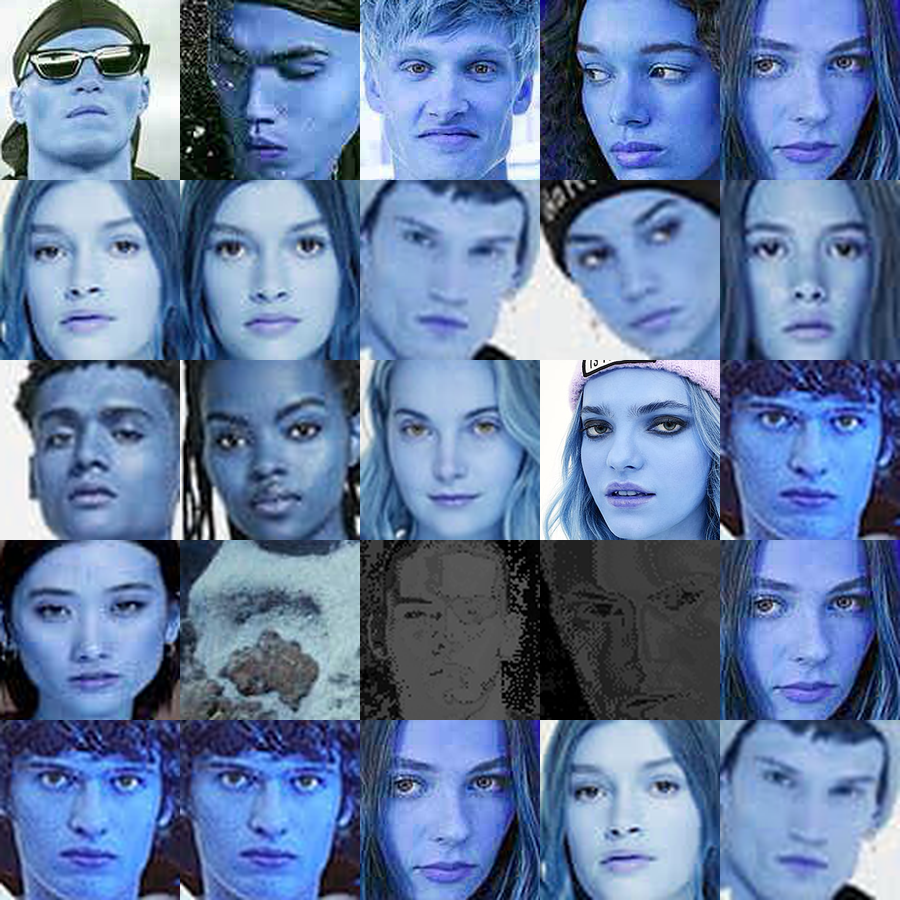

In [114]:
res = Imagen.create_image(filas*vhsize,filas*vhsize)
res = Imagen.img(res)
i = 0
for y in range(filas):
  for x in range(filas):
    res = Imagen.insert_image(res,recortes[i],x*vhsize,y*vhsize)
    i+=1
res
